<a href="https://www.kaggle.com/code/markkoltman/traffic-prediction-multiclass-imbalanced-classif?scriptVersionId=91905796" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Traffic Prediction - Multi-Class Imbalanced Classification


In this notebook, I will try to build a model that predicts the traffic situation in New York City, according to 3 levels: 0-Low,1-Medium ,2-High.

Using this model it will be possible to assess the future traffic situation within the city, based on a small number of features.

Given the 3 data sets, I will choose to use "nyc_traffic_ml_orig".


### A brief explanation of the variables in the table:

- Segment_ID: is an identifier for each street segment.

- Is_Weekend: tells whether it's a weekend or not.

- Daylight: lighting percentage (the hours of the day placed in a bell-curving function f(x) = (2)/(1 + np.exp(((x - 12)/4)^2))).

- Season1-4: One-Hot-Encoded Seasons (In this dataset, information about the summer is missing).

- Hr3-24: One-Hot-Encoded hours of the day to a 3 hour interval.

- Traffic_Volume: number of vehicles passing through a road over a period of hour (aggregated average for 3 hours).

- StreetWidth: standardized street width.

- UnitsRes_Prop:  percentage of residential units.

- NumFloors: numbers of floors.

- SubwayProximity: proximity to the Subway (1/NEAR_DIST).

- BoroCode1-5: One-Hot-Encoded of the five boroughs of New York City (Bronx, Brooklyn, Manhattan, Queens and Staten Island).

- LandUse_t1-5: environmental context (Residential, Commercial, Infrastructure, Public Institution, Open Space)

### Exploratory Analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


In [2]:
#Load and check data
df = pd.read_csv("../input/nyc-traffic-data/nyc_traffic_ml_orig.csv")
df.head()

,Segment_ID,Is_Weekend,Daylight,Season1,Season2,Season4,Hr3,Hr6,Hr9,Hr12,...,BoroCode1,BoroCode2,BoroCode3,BoroCode4,BoroCode5,LandUse_t1,LandUse_t2,LandUse_t3,LandUse_t4,LandUse_t5
0,132595,0,0.012580,0,0,1,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.764192,0.122271,0.026201,0.052402,0.034934
1,132595,0,0.190699,0,0,1,0,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.764192,0.122271,0.026201,0.052402,0.034934
2,132595,0,0.725938,0,0,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.764192,0.122271,0.026201,0.052402,0.034934
3,132595,0,1.000000,0,0,1,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.764192,0.122271,0.026201,0.052402,0.034934
4,132595,0,0.725938,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.764192,0.122271,0.026201,0.052402,0.034934


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28904 entries, 0 to 28903
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Segment_ID       28904 non-null  int64  
 1   Is_Weekend       28904 non-null  int64  
 2   Daylight         28904 non-null  float64
 3   Season1          28904 non-null  int64  
 4   Season2          28904 non-null  int64  
 5   Season4          28904 non-null  int64  
 6   Hr3              28904 non-null  int64  
 7   Hr6              28904 non-null  int64  
 8   Hr9              28904 non-null  int64  
 9   Hr12             28904 non-null  int64  
 10  Hr15             28904 non-null  int64  
 11  Hr18             28904 non-null  int64  
 12  Hr21             28904 non-null  int64  
 13  Hr24             28904 non-null  int64  
 14  Traffic_Volume   28904 non-null  float64
 15  StreetWidth      28904 non-null  float64
 16  UnitsRes_Prop    28904 non-null  float64
 17  NumFloors   

In [4]:
#check for null and missing values
df.isnull().sum().max()

0

In [5]:
#descriptive statistics summary
df['Traffic_Volume'].describe()

count    28904.000000
mean       764.612696
std        908.095757
min          0.000000
25%        199.670000
50%        463.895000
75%        927.260000
max       8096.580000
Name: Traffic_Volume, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Traffic_Volume', ylabel='Density'>

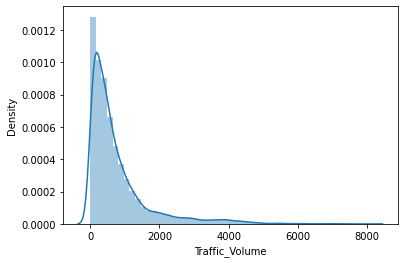

In [6]:
#distribution plot
sns.distplot(df['Traffic_Volume'])

A distribution plot of the traffic volume shows the large number of samples belonging to a low traffic volume, and that there are too few examples for higher traffic volume.

I will deal with the imbalance of our target values later.

In [7]:
#the correlation of the target variable
df = df[['Traffic_Volume']+[c for c in df.columns if c != 'Traffic_Volume']]
corrmat = df.corr()
corr_df = pd.DataFrame(corrmat.values[0,:], index=df.columns, columns=['target_corr'])
corr_df = corr_df.drop(['Traffic_Volume'])
corr_df

,target_corr
Segment_ID,0.116459
Is_Weekend,-0.040083
Daylight,0.119452
Season1,-0.043947
Season2,-0.071963
Season4,0.085836
Hr3,-0.175787
Hr6,-0.203146
Hr9,0.006273
Hr12,0.062431


Since there are so many variables, I will take the variables with highst correlations with our target.

In [8]:
#choosing the highs correlation variables
k = 15
cols = corrmat.nlargest(k, 'Traffic_Volume')['Traffic_Volume'].index
cols = [col for col in cols if col != 'Traffic_Volume']
cols

['LandUse_t5',
 'Hr18',
 'Daylight',
 'Segment_ID',
 'LandUse_t3',
 'Hr15',
 'BoroCode1',
 'Hr21',
 'Season4',
 'Hr12',
 'NumFloors',
 'BoroCode4',
 'StreetWidth',
 'Hr9']

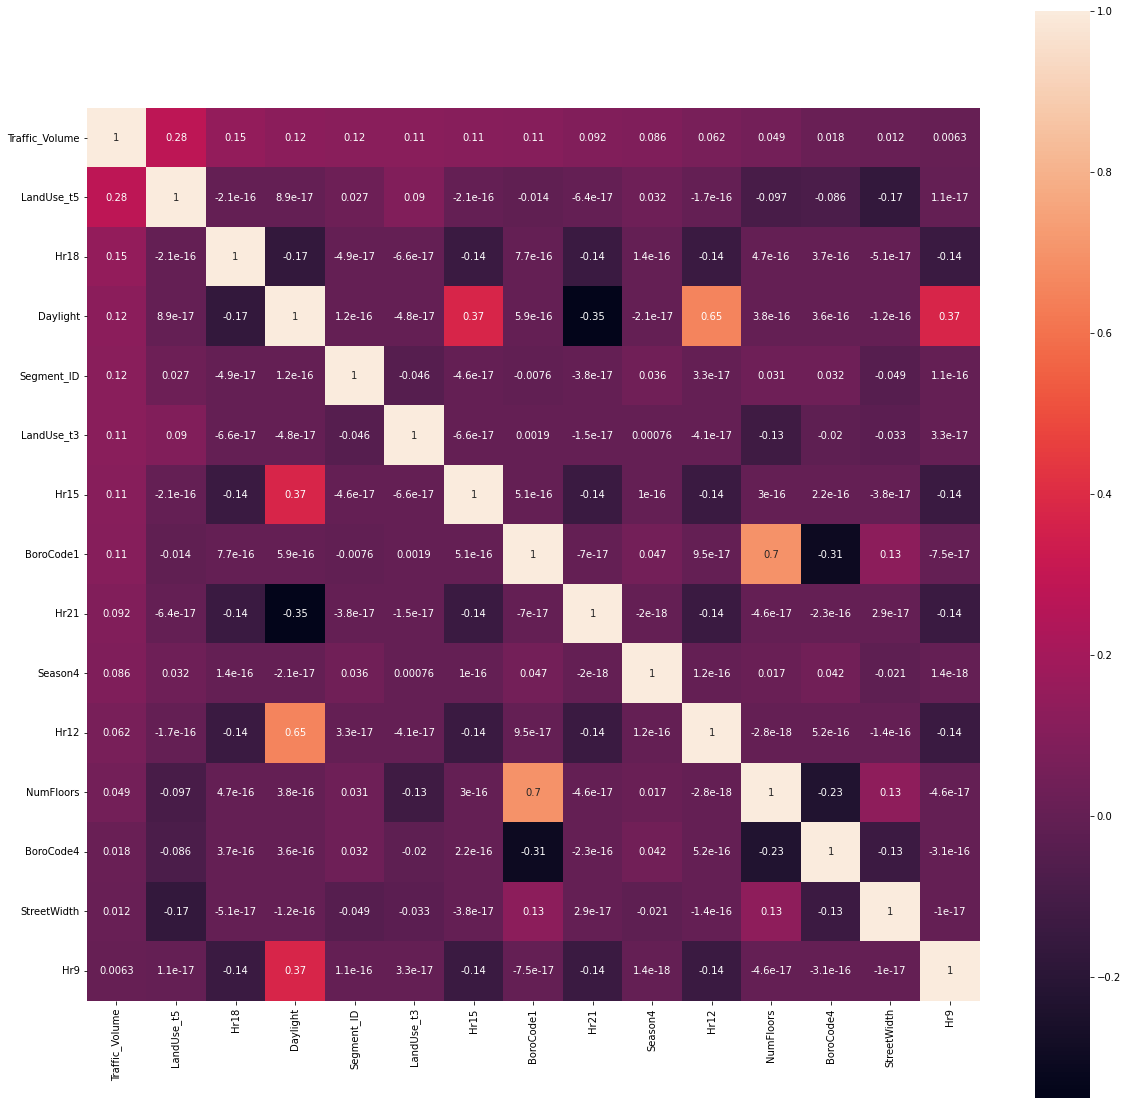

In [9]:
#correlation matrix
corrmat_sel = df[['Traffic_Volume'] + list(cols)].corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat_sel, cbar=True, annot=True, square=True);

It can be seen that there are high correlations between the daytime hours and the Daylight feature (remember that Daylight is derived from them), so I will remove the daytime hours from the list.

In [10]:
cols = [col for col in cols if col not in ['Hr9','Hr12','Hr15','Hr18','Hr21']]
cols

['LandUse_t5',
 'Daylight',
 'Segment_ID',
 'LandUse_t3',
 'BoroCode1',
 'Season4',
 'NumFloors',
 'BoroCode4',
 'StreetWidth']

now lets categorize the target Traffic_Volume:

In [11]:
#categorizing the target
max_value = df['Traffic_Volume'].max()
split_1, split_2 = max_value/3, max_value*2/3
print(split_1, split_2)
df['Traffic_Volume'] = pd.cut(df['Traffic_Volume'], bins=[0,split_1,split_2,np.inf], include_lowest=True, labels=[0, 1, 2])

2698.86 5397.72


Class=0, n=27366 (94.679%)
Class=1, n=1461 (5.055%)
Class=2, n=77 (0.266%)


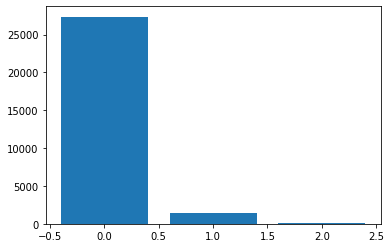

In [12]:
# summarize distribution
y = df['Traffic_Volume'].values
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.bar(counter.keys(), counter.values())
plt.show()

It can be seen that there is a problem of highly imbalanced classes, which can make our classifier to be more biased towards the majority class, causing bad classification of the minority class.
To deal with this problem I will use SMOTE Oversampling which synthesizing new examples of the minority classes so that the number of examples in the minority class matches the number of examples in the majority classes.

### Modeling

In [13]:
#train test splitting
X = df[cols]
y = df['Traffic_Volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

Class=0, n=19139 (33.333%)
Class=1, n=19139 (33.333%)
Class=2, n=19139 (33.333%)


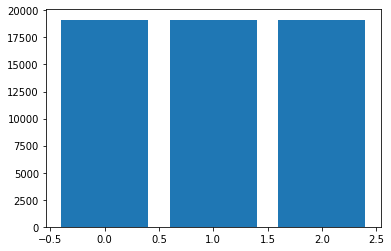

In [14]:
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()


In [15]:
#Building a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
#evaluate a model
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

scores = evaluate_model(X_train, y_train, clf)
scores.mean()

0.97967500940997

I got an accuracy that looks pretty good, but keep in mind that for imbalanced data the accuracy metric is not a good metric for measuring the correctness of our model.

To get a better idea of how our model is performing I will use Confusion Matrix.

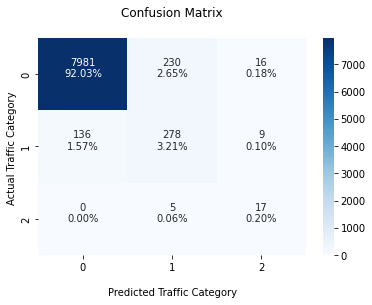

In [17]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Traffic Category')
ax.set_ylabel('Actual Traffic Category ');
ax.xaxis.set_ticklabels(['0','1', '2'])
ax.yaxis.set_ticklabels(['0','1', '2'])
plt.show()

From the Confusion Matrix it can be seen that the results are not very good, and the model tends to classify the classes with the higher traffic to the lower class. But given the large imbalance in the given data (94.7% - 5% - 0.3%), the model still classifies most of the samples in each class correctly.

Probably if we have more samples with high traffic volume (not just 77), our model will give better results and can provide us more reliable predictions.

